# Neural Spline Flow

In [1]:
# Import required packages
import torch
import numpy as np
import normflows as nf
from torchviz import make_dot
from sklearn.datasets import make_moons
from scipy.special import erf, gamma
from matplotlib import pyplot as plt
import benchmark
import xfacpy
from tqdm import tqdm
import functools

In [2]:
# Set up flow model
ndims = 2
batchsize = 1000
delta = 0.3

sigma_x = 0.1
sigma_y = 1.0

# Create diagonal covariance matrix
cov = torch.diag(torch.tensor([sigma_x**2, sigma_y**2]))
theta = torch.tensor(np.pi / 4)
target = benchmark.Gauss(1000,ndims,cov, theta)
#target = benchmark.Sharp(batchsize)
# Define flows
K = 2
torch.manual_seed(0)

latent_size = ndims
hidden_units = 4
num_blocks = 2

flows = []
#for i in range(K):
    #flows += [nf.flows.CoupledRationalQuadraticSpline(latent_size, num_blocks, hidden_units)]
    #flows += [nf.flows.LULinearPermute(latent_size)]
flows += [nf.flows.CoupledRationalQuadraticSpline(latent_size, num_blocks, hidden_units)]
flows += [nf.flows.CoupledRationalQuadraticSpline(latent_size, num_blocks, hidden_units, reverse_mask=True)]
# for mask in masks[::-1]:
#     flows += [nf.flows.CoupledRationalQuadraticSpline(latent_size, num_blocks, hidden_units, mask=mask)]
# Set base distribuiton
q0 = nf.distributions.base.Uniform(2, 0.0, 1.0)
    
# Construct flow model
nfm = nf.NormalizingFlow(q0, flows, target)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)

In [3]:
print("total model params",sum(p.numel() for p in nfm.parameters() if p.requires_grad))

total model params 452


/home/wangtao/miniconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


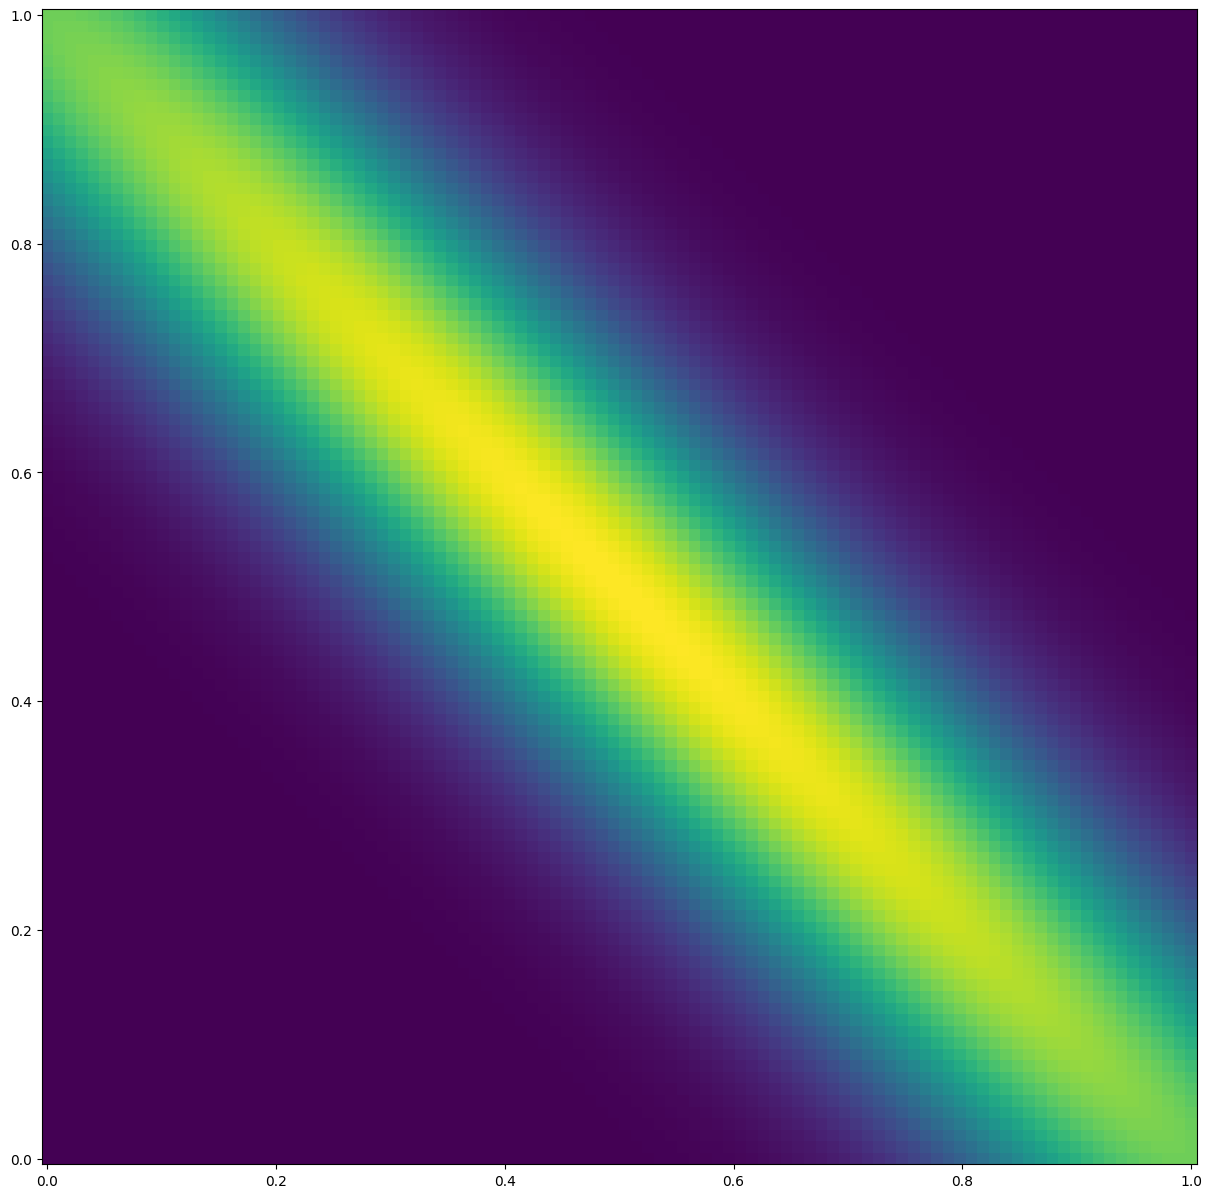

In [4]:
# Plot target distribution
# x_np, _ = make_moons(2 ** 20, noise=0.1)
# plt.figure(figsize=(15, 15))
# plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200)
# plt.show()

# Plot initial flow distribution
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(0.0, 1.0, grid_size), torch.linspace(0.0, 1.0, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

nfm.eval()
log_prob = nfm.p.log_prob(zz).to('cpu').view(*xx.shape)
prob = nfm.p.prob(zz).to('cpu').view(*xx.shape)
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

In [7]:
#Generate corresponding tensor based on the indices
#xell is the grid of one dimension. Here we use the same uniform grid for all dimensions
#nfm is the flow model.
def Ptensor(I, J, zell, ndims, nfm):
    # Generate input tensor
    z = torch.zeros(len(I),len(J),ndims)
    for i, Idex in enumerate(I):
        for j, Jdex in enumerate(J):
            z[i,j,:] = torch.tensor(np.array([zell[k] for k in Idex+Jdex])) 
    #result = torch.tensor(x2)
    #print("test:",result)
    znewshape = (torch.prod(torch.tensor(z.shape[0:-1])).item(), z.shape[-1])
    
    # Reshape the input z two 2D tensor, (batchsize, ndims), required by the flow.prob.
    x, logJ = nfm.forward_and_log_det(z.view(znewshape))
    result = torch.exp(nfm.p.log_prob(x) + logJ)
    # Reshape back to the Matrix form for loss calculation
    return result.view(z.shape[0:-1])

def Ttensor(I, P, J, zell, ndims, nfm):
    z = torch.zeros(len(I),len(P), len(J), ndims)
    for i, Idex in enumerate(I):
        for p, Pdex in enumerate(P):
            for j, Jdex in enumerate(J):
                z[i,p,j,:] = torch.tensor(np.array([zell[k] for k in Idex+[Pdex]+Jdex])) 
    znewshape = (torch.prod(torch.tensor(z.shape[0:-1])).item(), z.shape[-1])
    
    # Reshape the input z two 2D tensor, (batchsize, ndims), required by the flow.prob.
    x, logJ = nfm.forward_and_log_det(z.view(znewshape))
    result = torch.exp(nfm.p.log_prob(x) + logJ)
    # Reshape back to the Matrix form for loss calculation
    return result.view(z.shape[0:-1])

def Pitensor(I, P1, P2, J, zell, ndims, nfm):
    z = torch.zeros(len(I),len(P1), len(P2),len(J), ndims)
    for i, Idex in enumerate(I):
        for p1, P1dex in enumerate(P1):
            for p2,P2dex in enumerate(P2):
                for j, Jdex in enumerate(J):
                    z[i,p1,p2,j,:] = torch.tensor(np.array([zell[k] for k in Idex+[P1dex]+[P2dex]+Jdex])) 
    znewshape = (torch.prod(torch.tensor(z.shape[0:-1])).item(), z.shape[-1])
    
    # Reshape the input z two 2D tensor, (batchsize, ndims), required by the flow.prob.
    x, logJ = nfm.forward_and_log_det(z.view(znewshape))
    result = torch.exp(nfm.p.log_prob(x) + logJ)
    # Reshape back to the Matrix form for loss calculation
    return result.view(z.shape[0:-1])



def insample_error(T1,P,T2,Pi):
    T2newshape =(T2.shape[0], torch.prod(torch.tensor(T2.shape[1:])).item()) 
    T1newshape =(torch.prod(torch.tensor(T1.shape[0:-1])).item(), T1.shape[-1]) 
    Pinewshape =(T1newshape[0], T2newshape[1]) 
    return Pi.view(Pinewshape) - T1.view(T1newshape) @ torch.linalg.solve(P, T2.view(T2newshape))

  1%|▍                                        | 19/2000 [00:07<12:07,  2.72it/s]

in-sample tci error 0.4759209401885869
loss tensor([0.0345], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.564109782633644


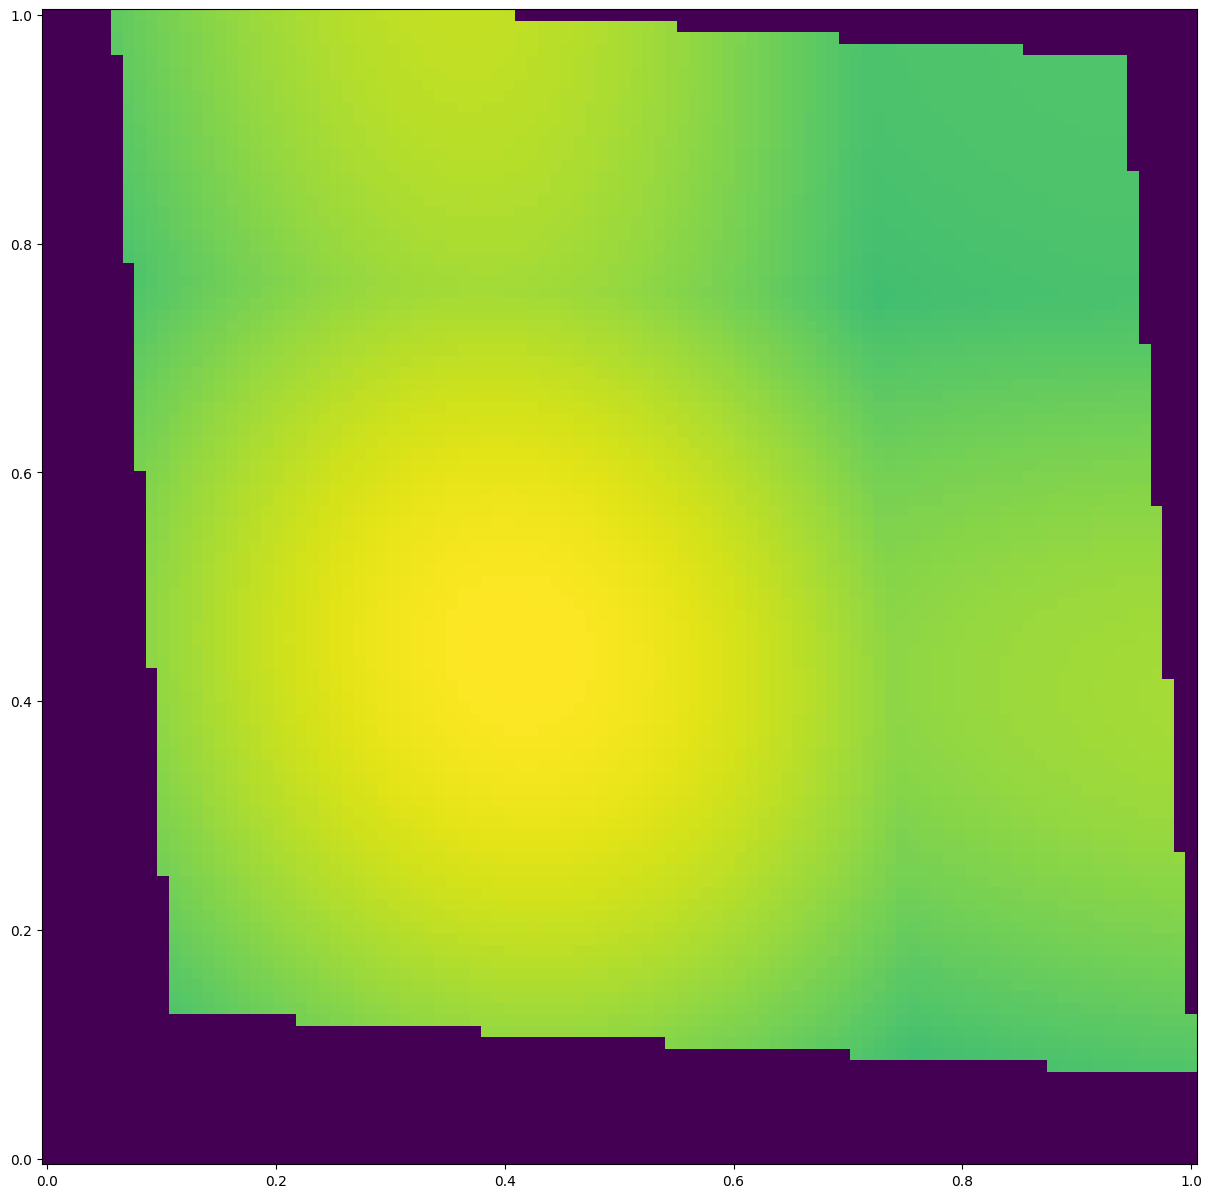

  2%|▊                                        | 39/2000 [00:16<14:07,  2.31it/s]

in-sample tci error 0.15398737935871765
loss tensor([0.0006], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.6689063464735376


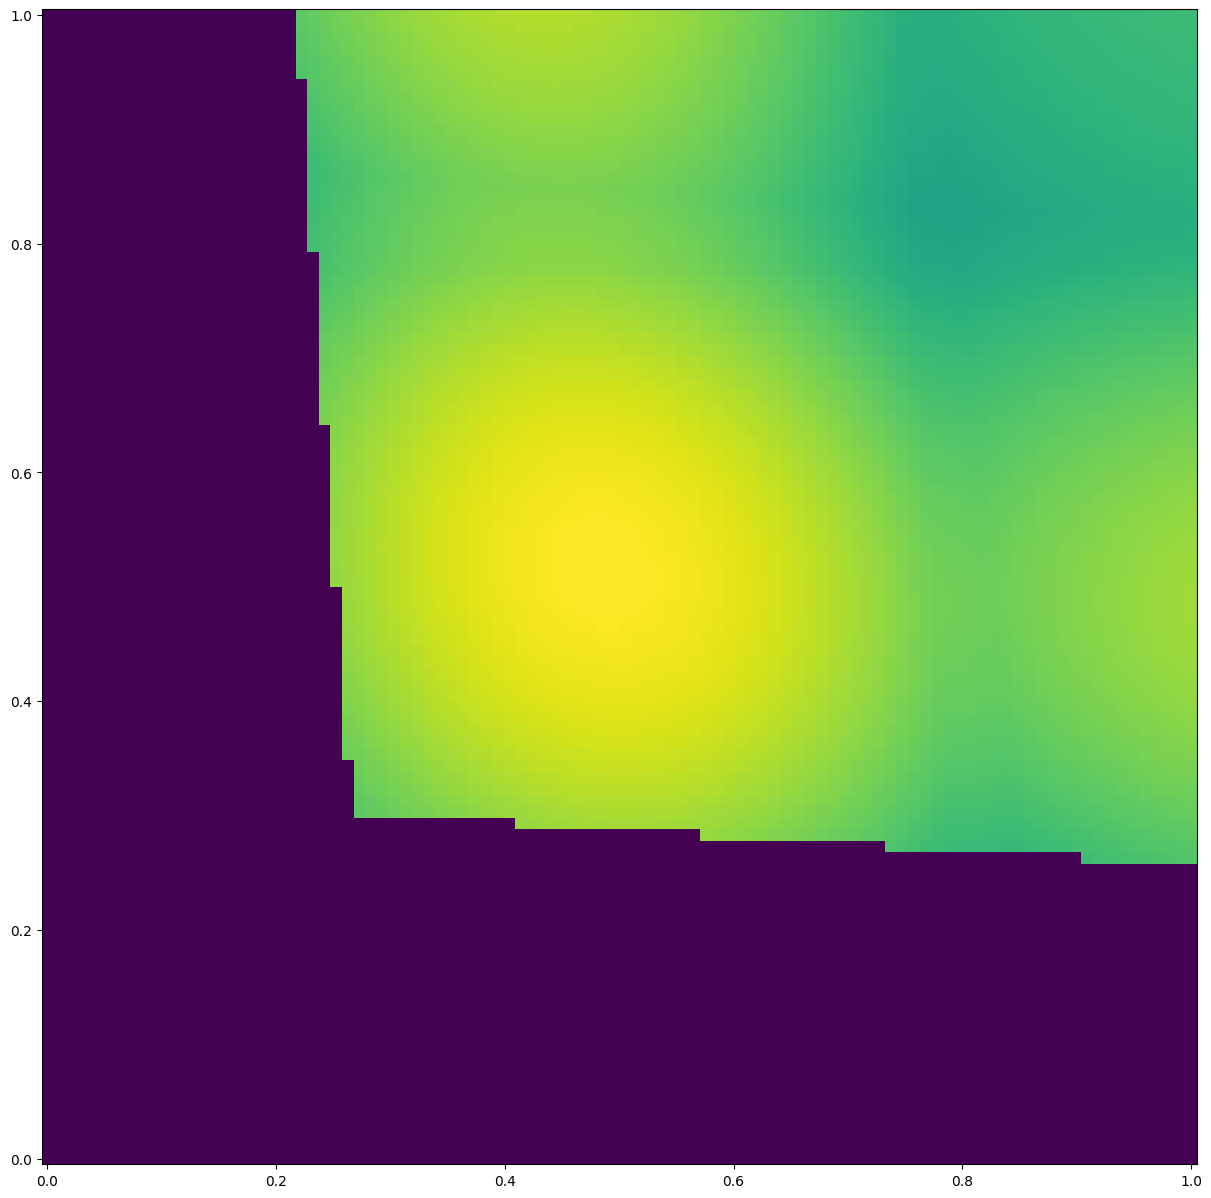

  3%|█▏                                       | 59/2000 [00:26<13:33,  2.39it/s]

in-sample tci error 0.0636644546397217
loss tensor([4.4895e-05], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.7545566919449085


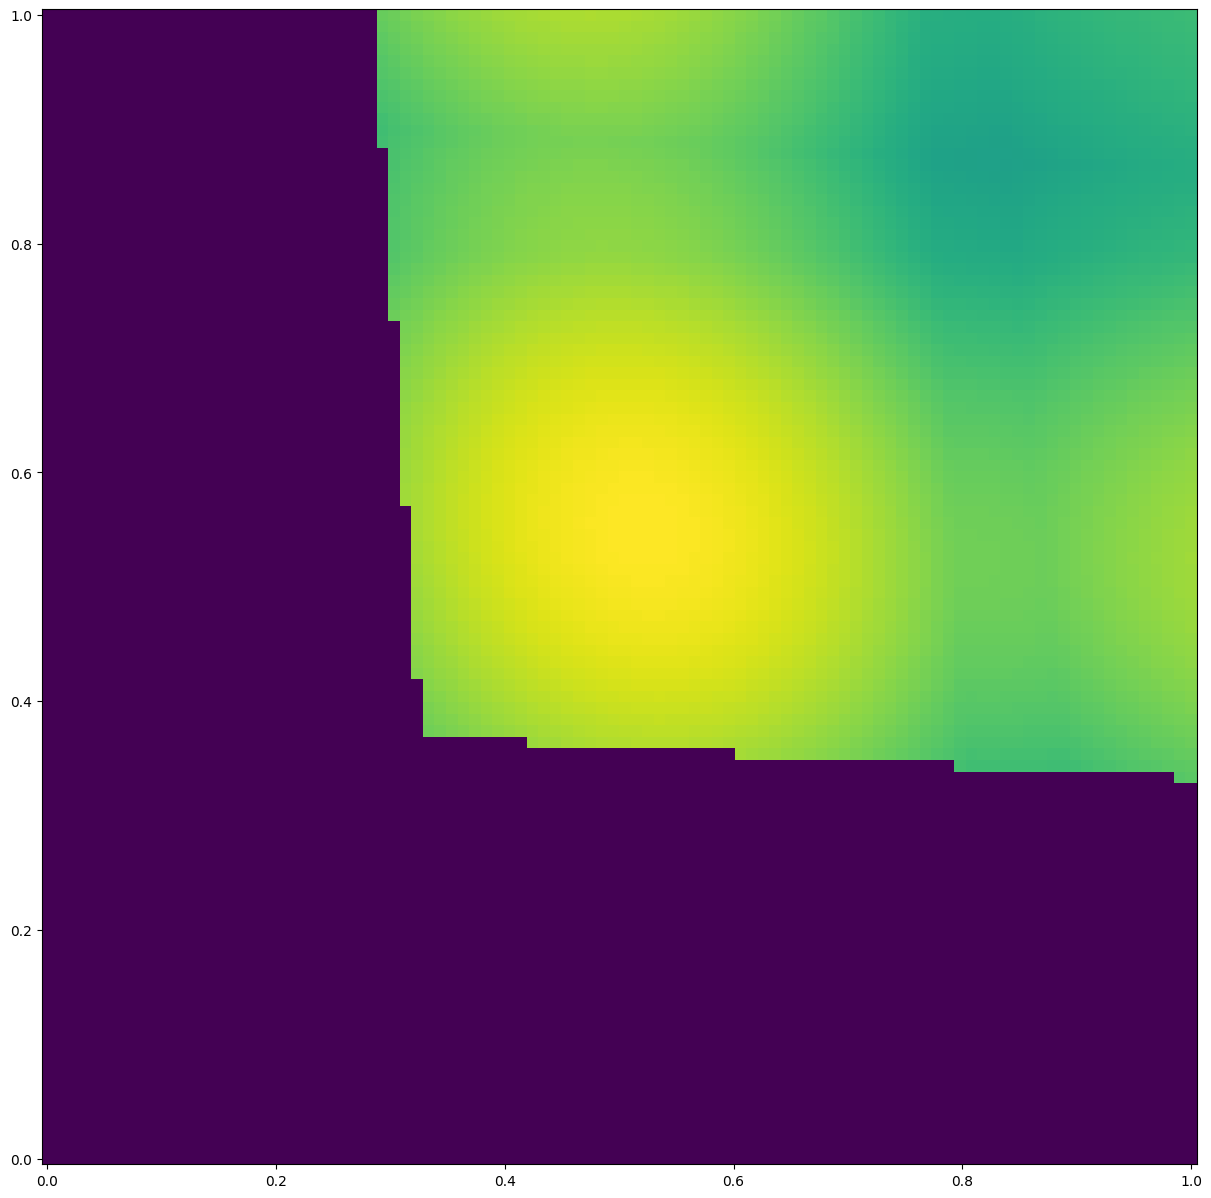

  4%|█▌                                       | 79/2000 [00:35<15:31,  2.06it/s]

in-sample tci error 0.036476216397195116
loss tensor([2.0479e-05], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.7755828326966645


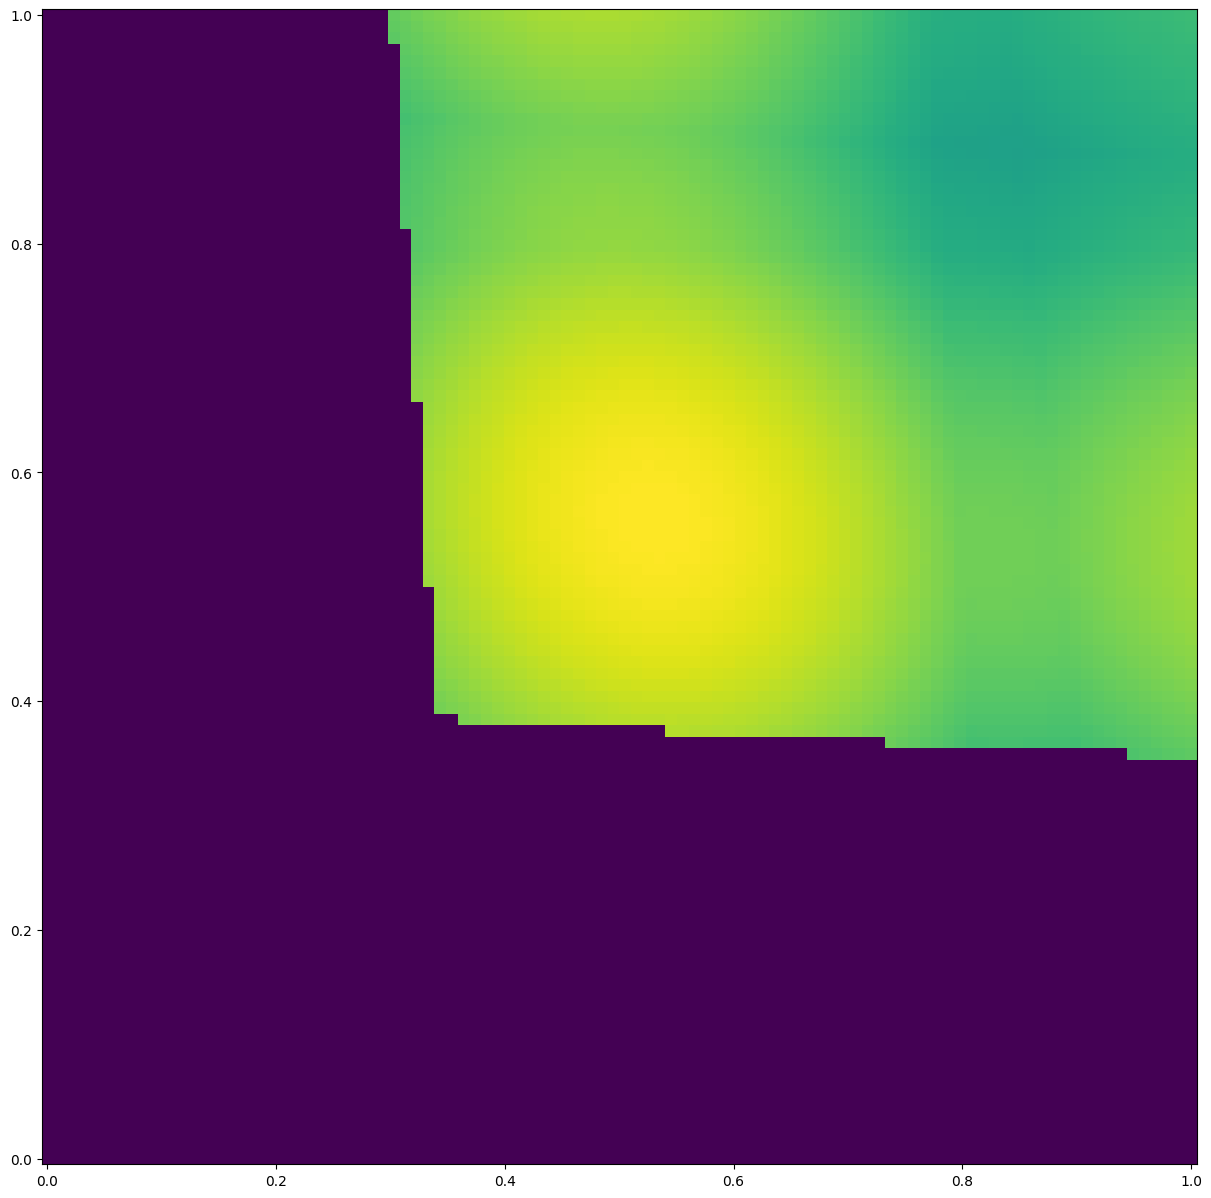

  5%|██                                       | 99/2000 [00:44<15:13,  2.08it/s]

in-sample tci error 0.031179934096049022
loss tensor([1.2712e-05], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.7825911426405856


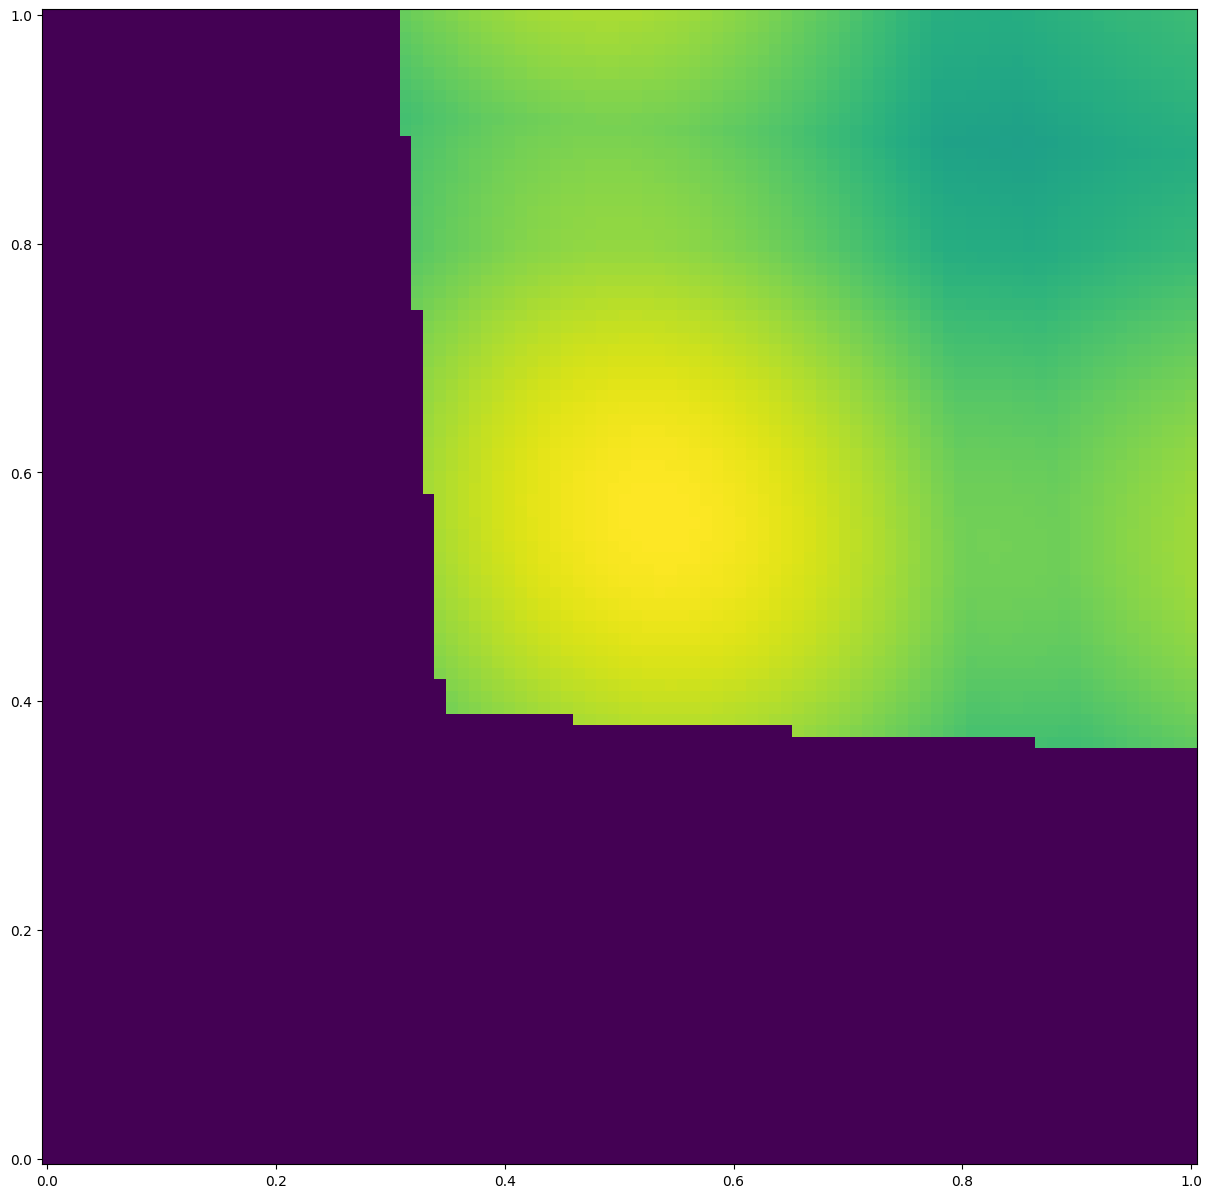

  6%|██▍                                     | 119/2000 [00:53<12:58,  2.42it/s]

in-sample tci error 0.029127756208934485
loss tensor([1.0629e-05], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.7864811800197753


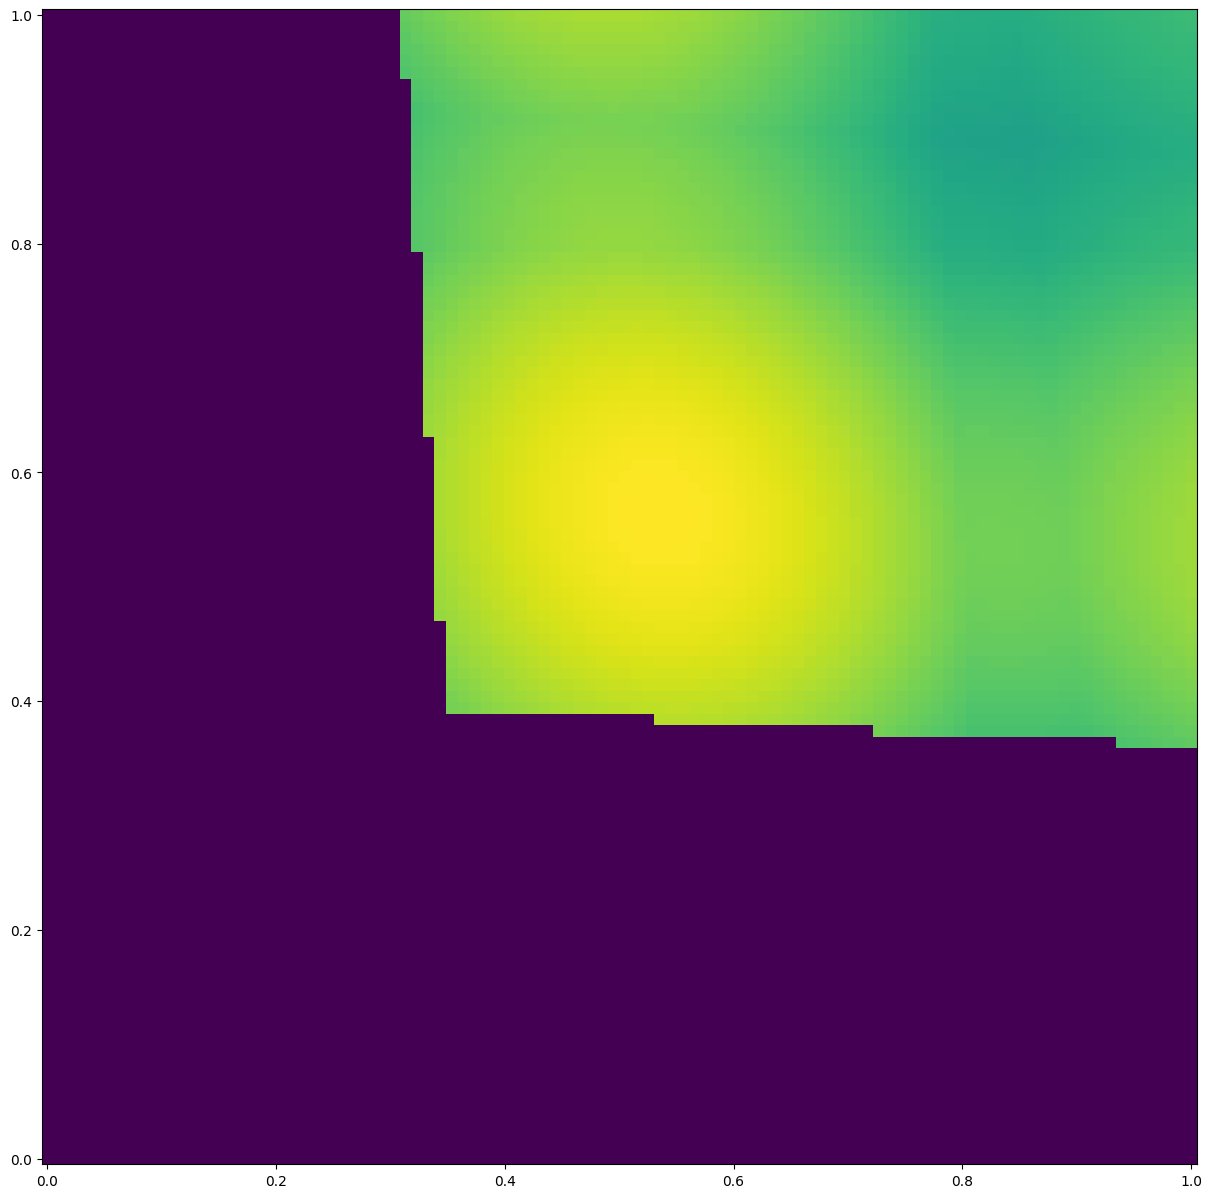

  7%|██▊                                     | 139/2000 [01:03<15:17,  2.03it/s]

in-sample tci error 0.07491096716245327
loss tensor([1.8449e-06], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.7902379213936848


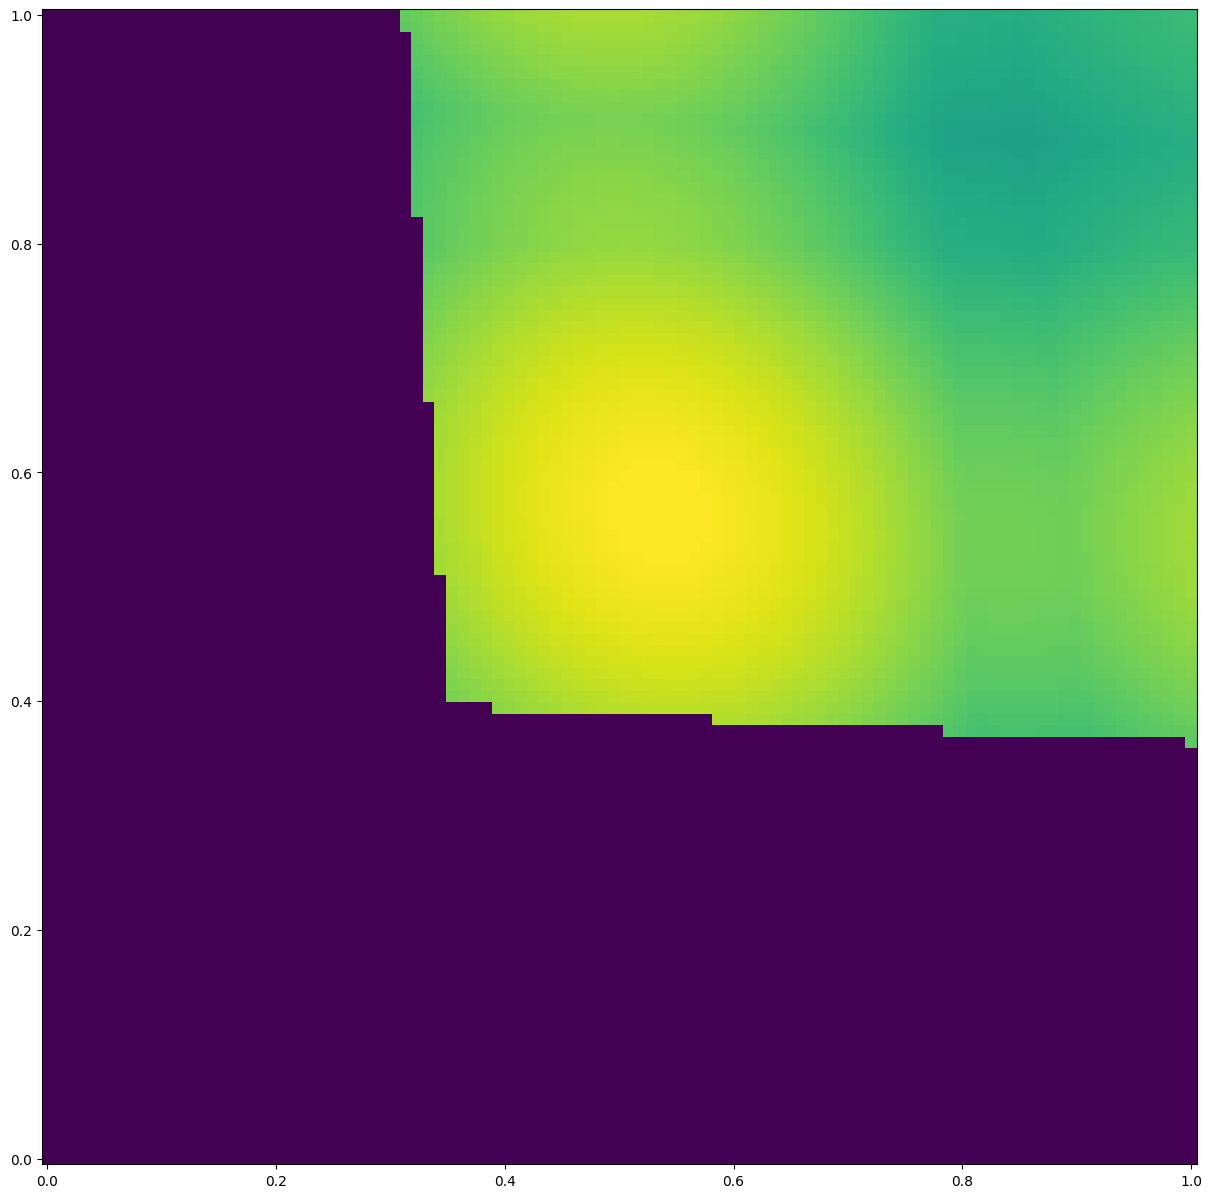

  8%|███▏                                    | 159/2000 [01:13<14:09,  2.17it/s]

in-sample tci error 0.06919535155227596
loss tensor([3.7822e-06], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.7923008868805352


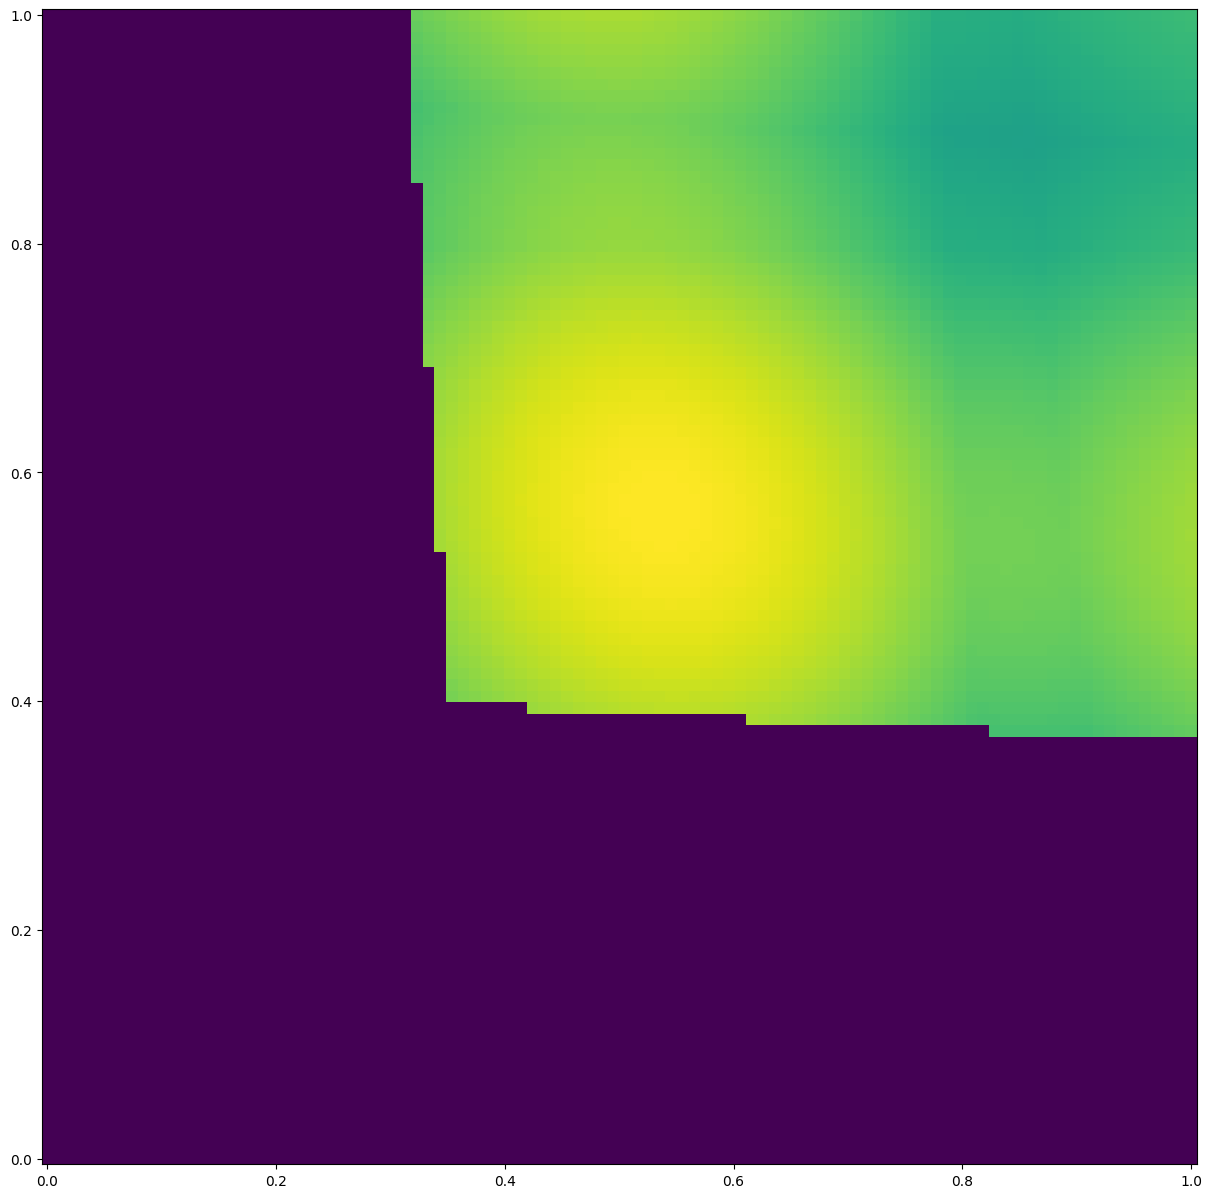

  9%|███▌                                    | 179/2000 [01:22<14:07,  2.15it/s]

in-sample tci error 0.06945879589752602
loss tensor([3.0224e-06], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.7938938498567585


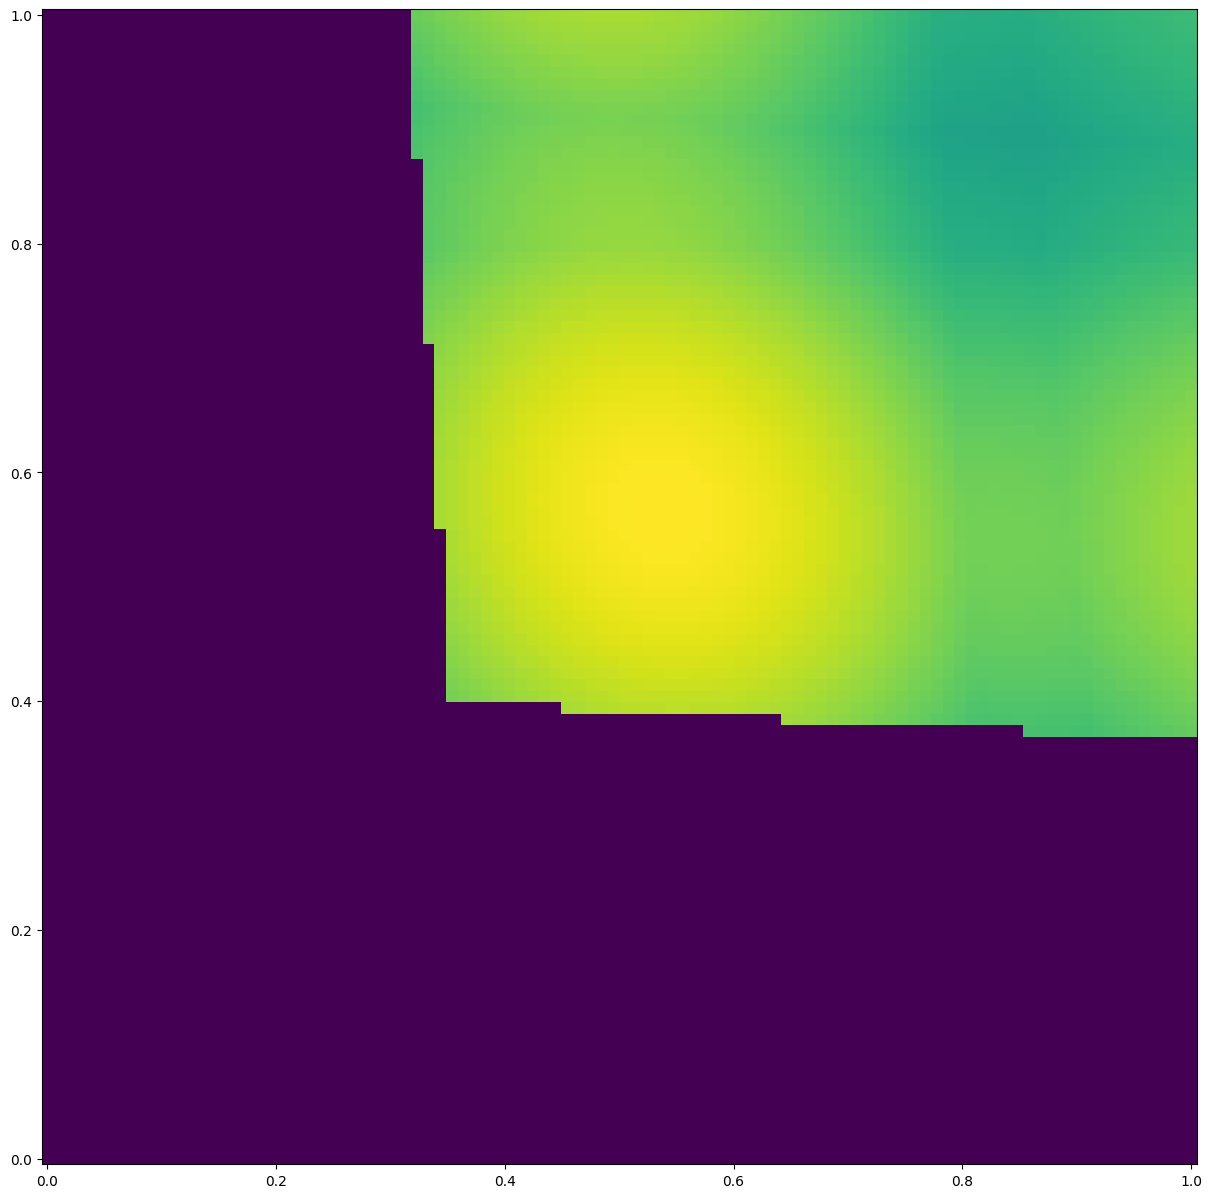

 10%|███▉                                    | 199/2000 [01:32<14:01,  2.14it/s]

in-sample tci error 0.12064182842613369
loss tensor([9.2564e-07], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.7948721441797724


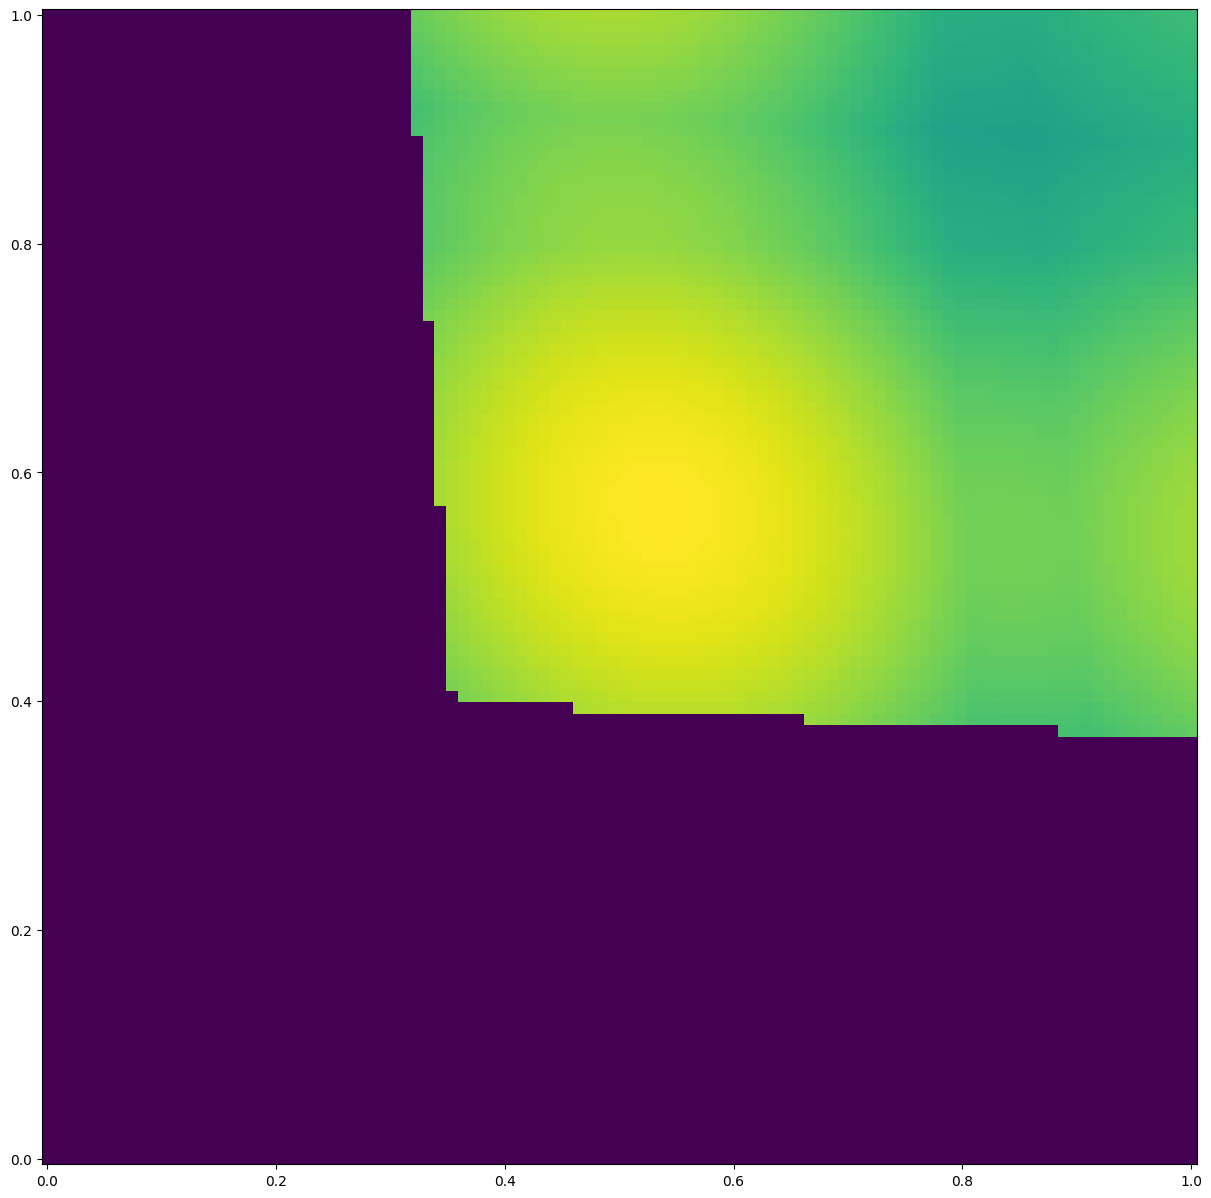

 11%|████▍                                   | 219/2000 [01:42<15:27,  1.92it/s]

in-sample tci error 0.11968579605303487
loss tensor([9.0803e-07], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.795320241464811


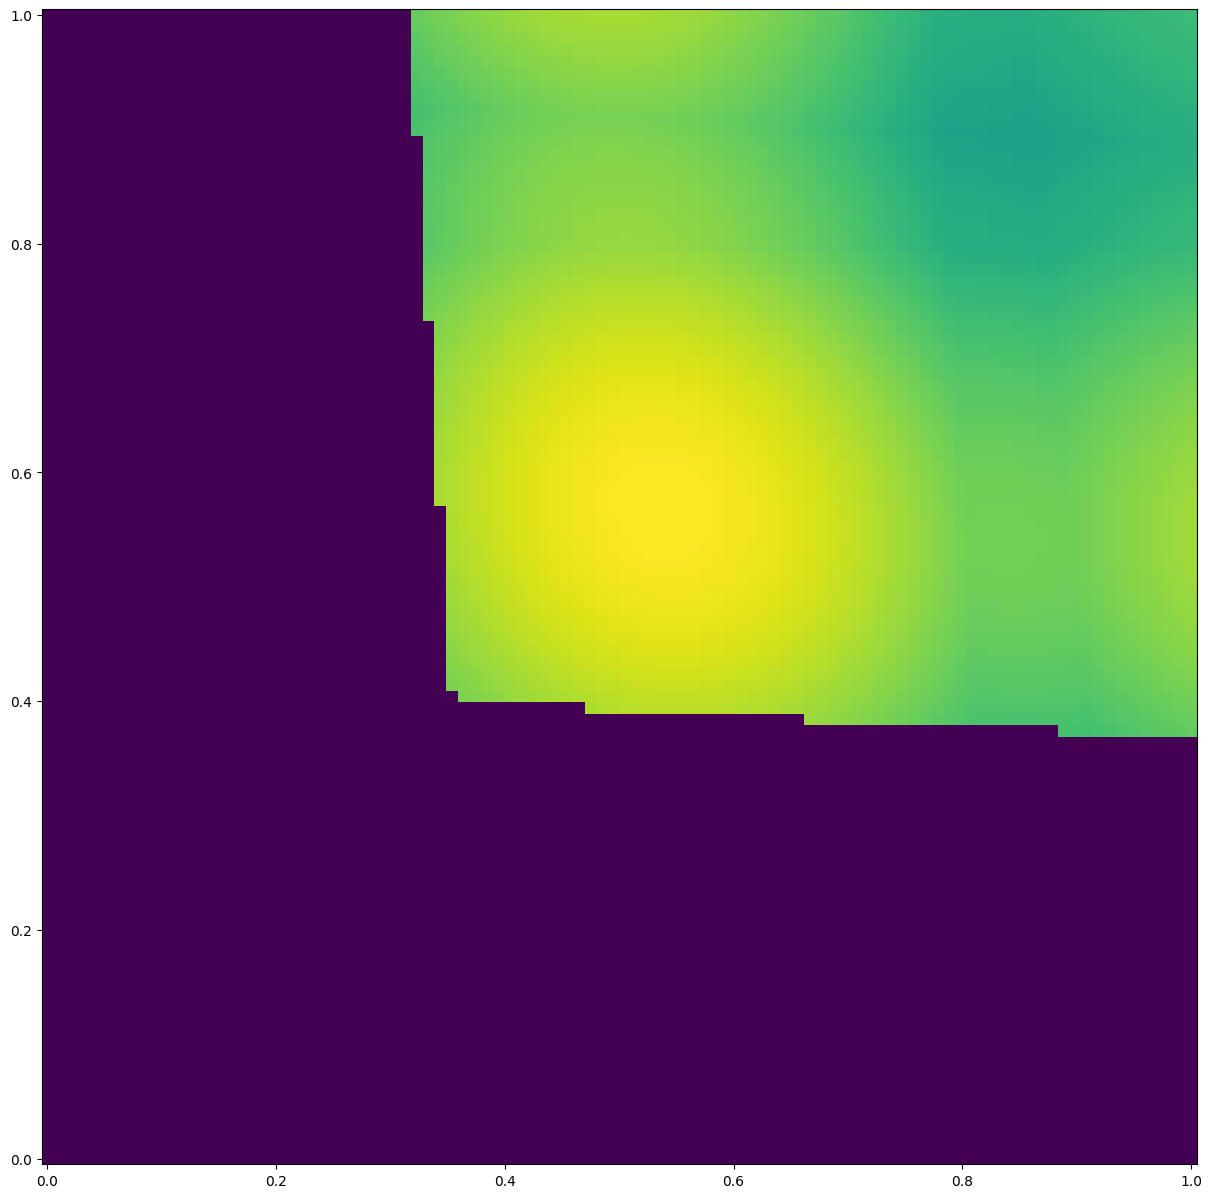

 12%|████▊                                   | 239/2000 [01:52<14:02,  2.09it/s]

in-sample tci error 0.11893410557767203
loss tensor([8.9369e-07], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.7956733196616494


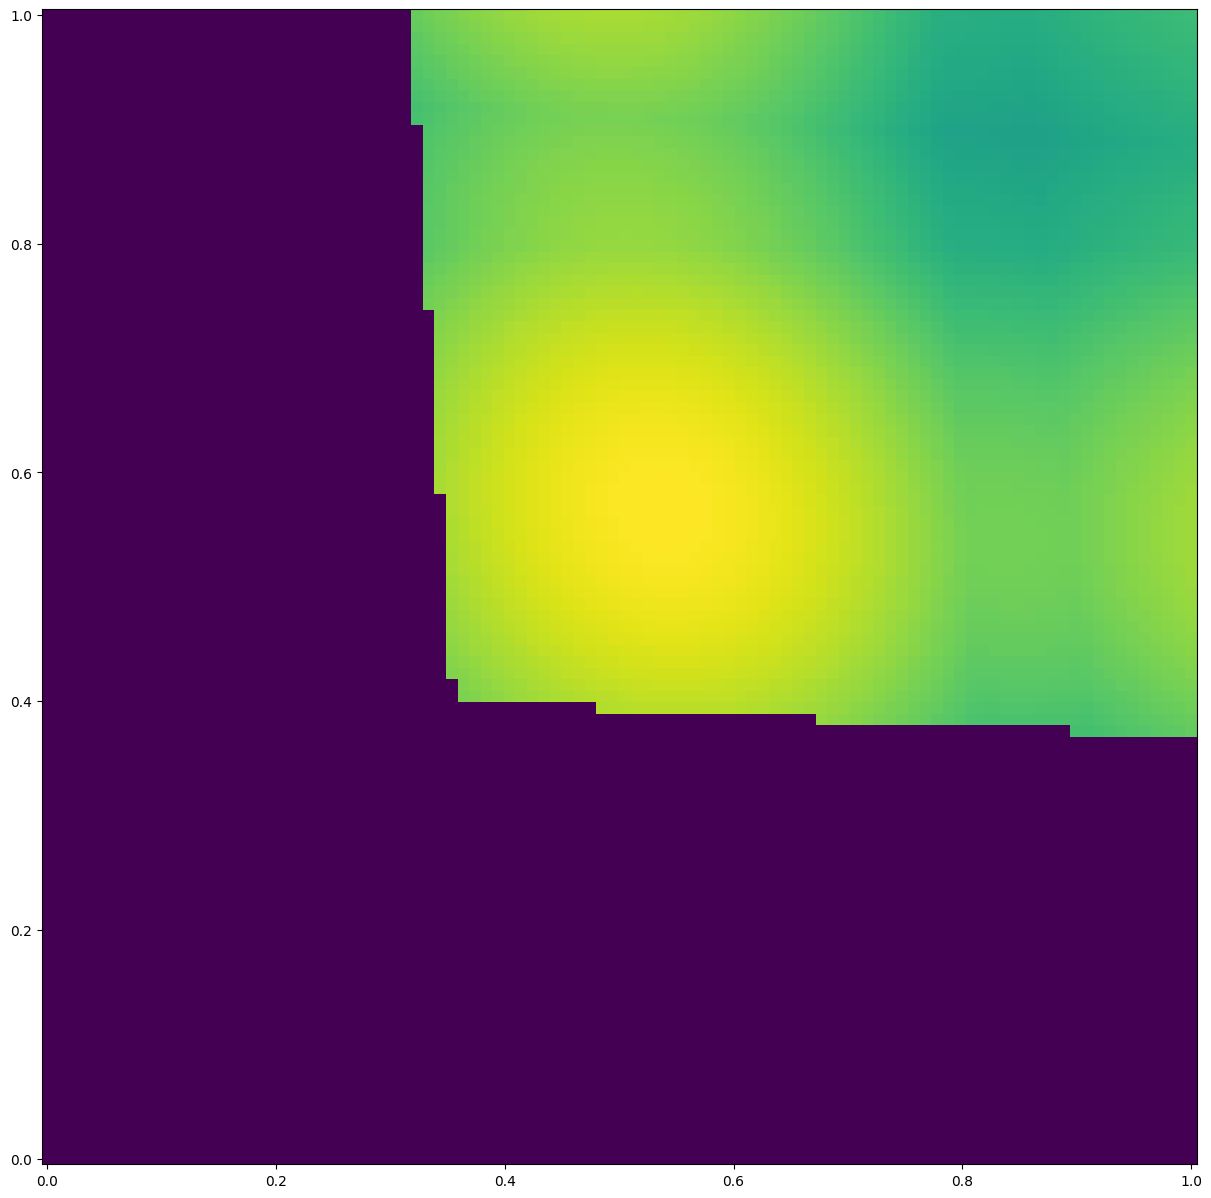

 13%|█████▏                                  | 259/2000 [02:00<11:57,  2.43it/s]

in-sample tci error 0.11819065905316295
loss tensor([8.8050e-07], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.7960217280391153


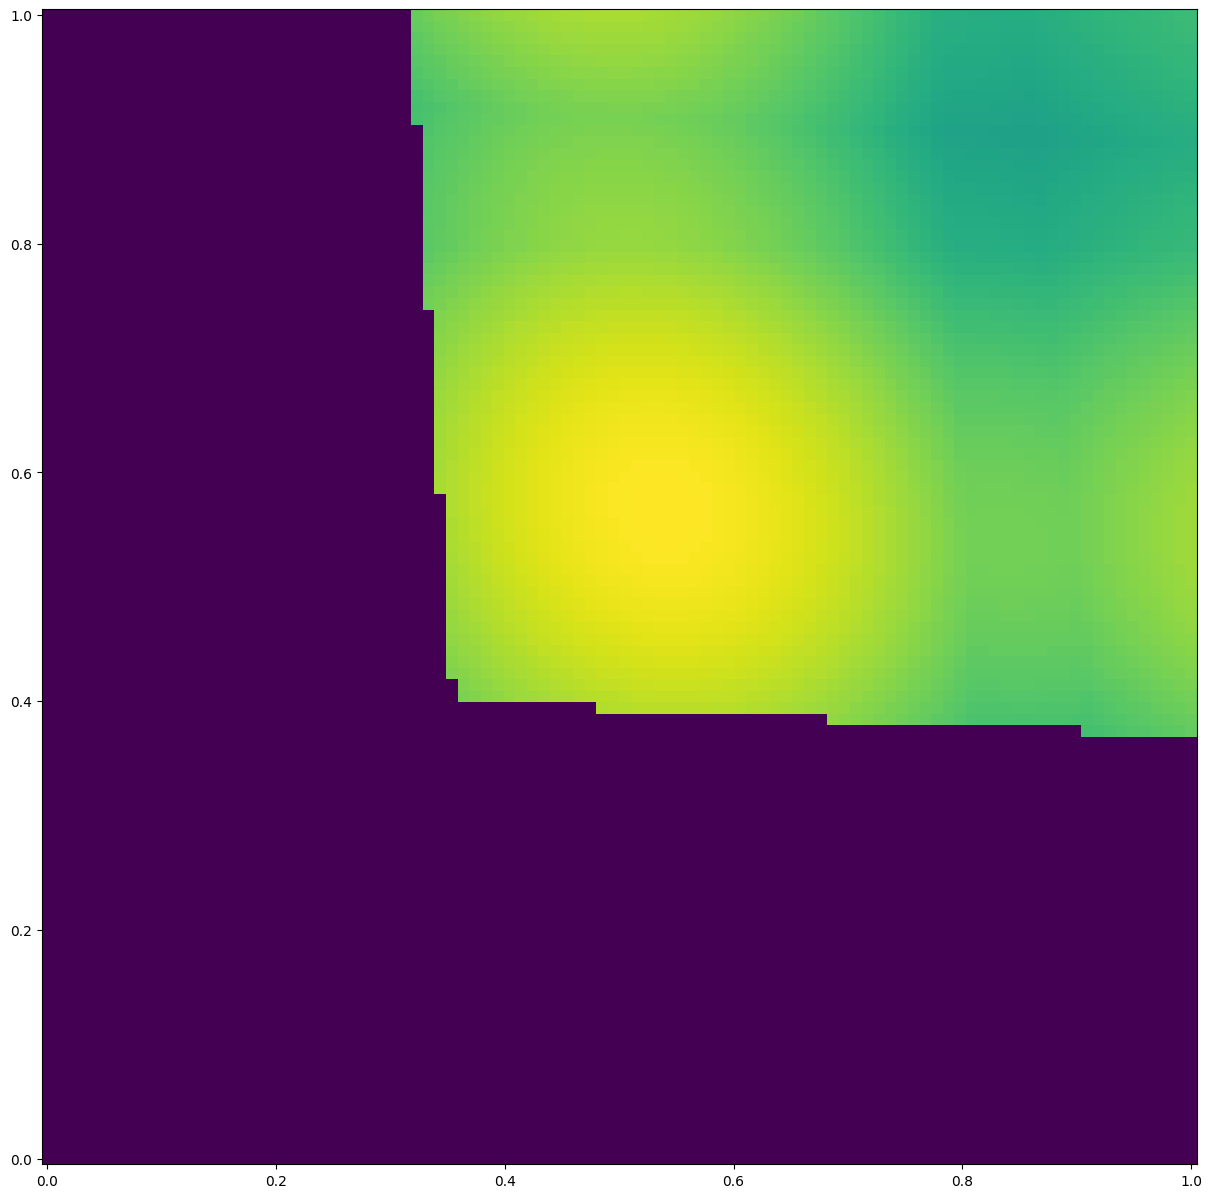

 14%|█████▌                                  | 279/2000 [02:09<11:25,  2.51it/s]

in-sample tci error 0.11303870415357975
loss tensor([8.6687e-07], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.796377324852037


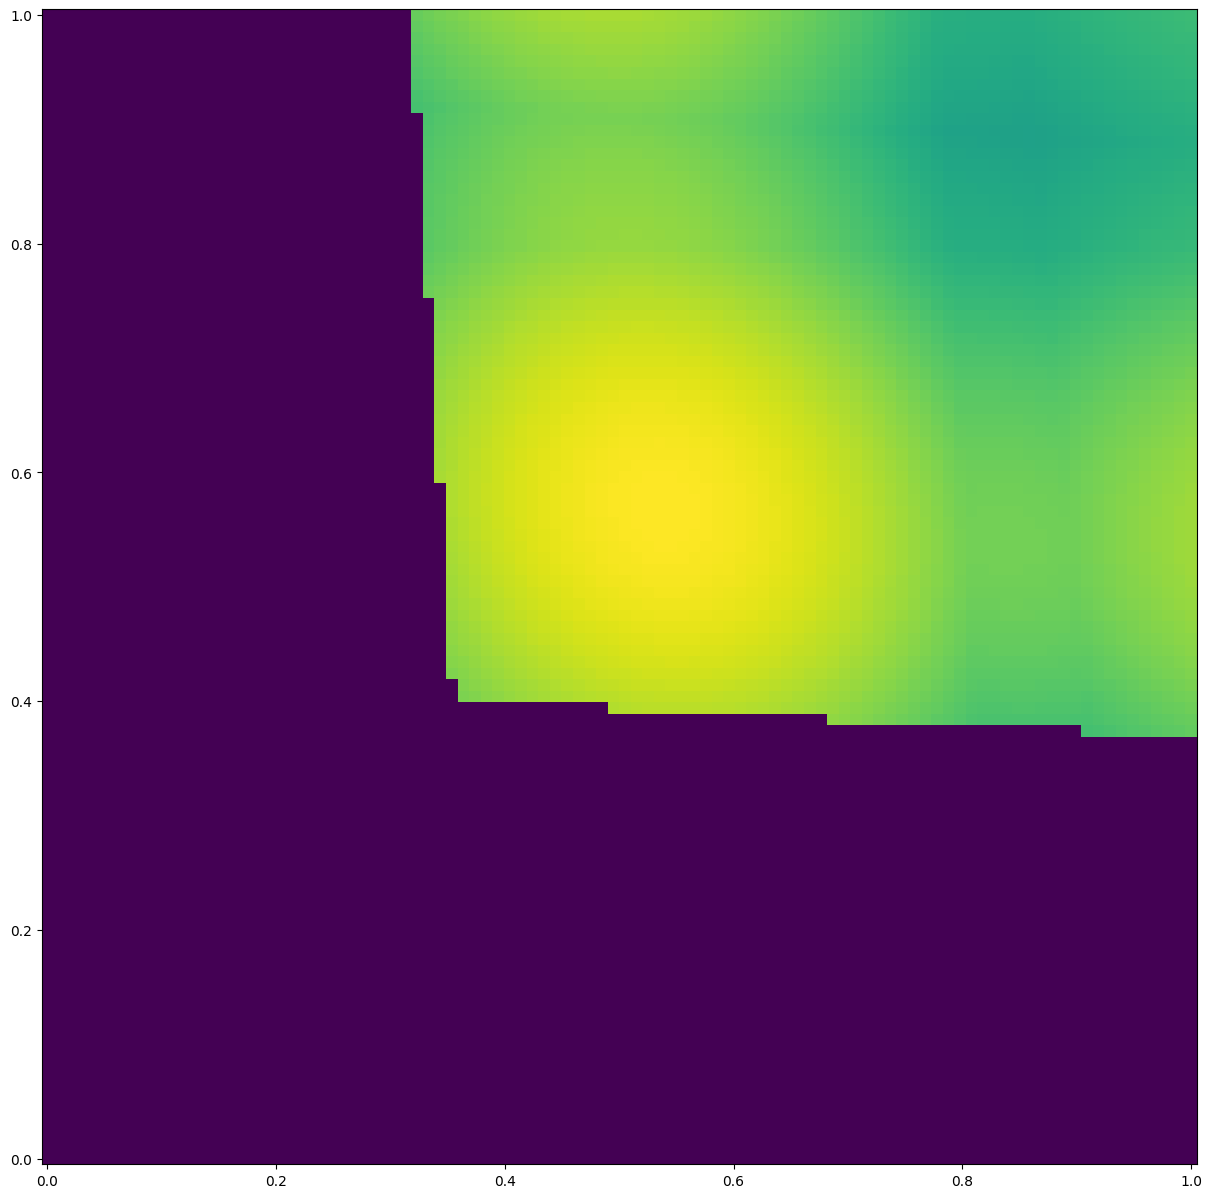

 15%|█████▉                                  | 299/2000 [02:17<12:31,  2.26it/s]

in-sample tci error 0.11666608878442553
loss tensor([8.5326e-07], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.7967401663195197


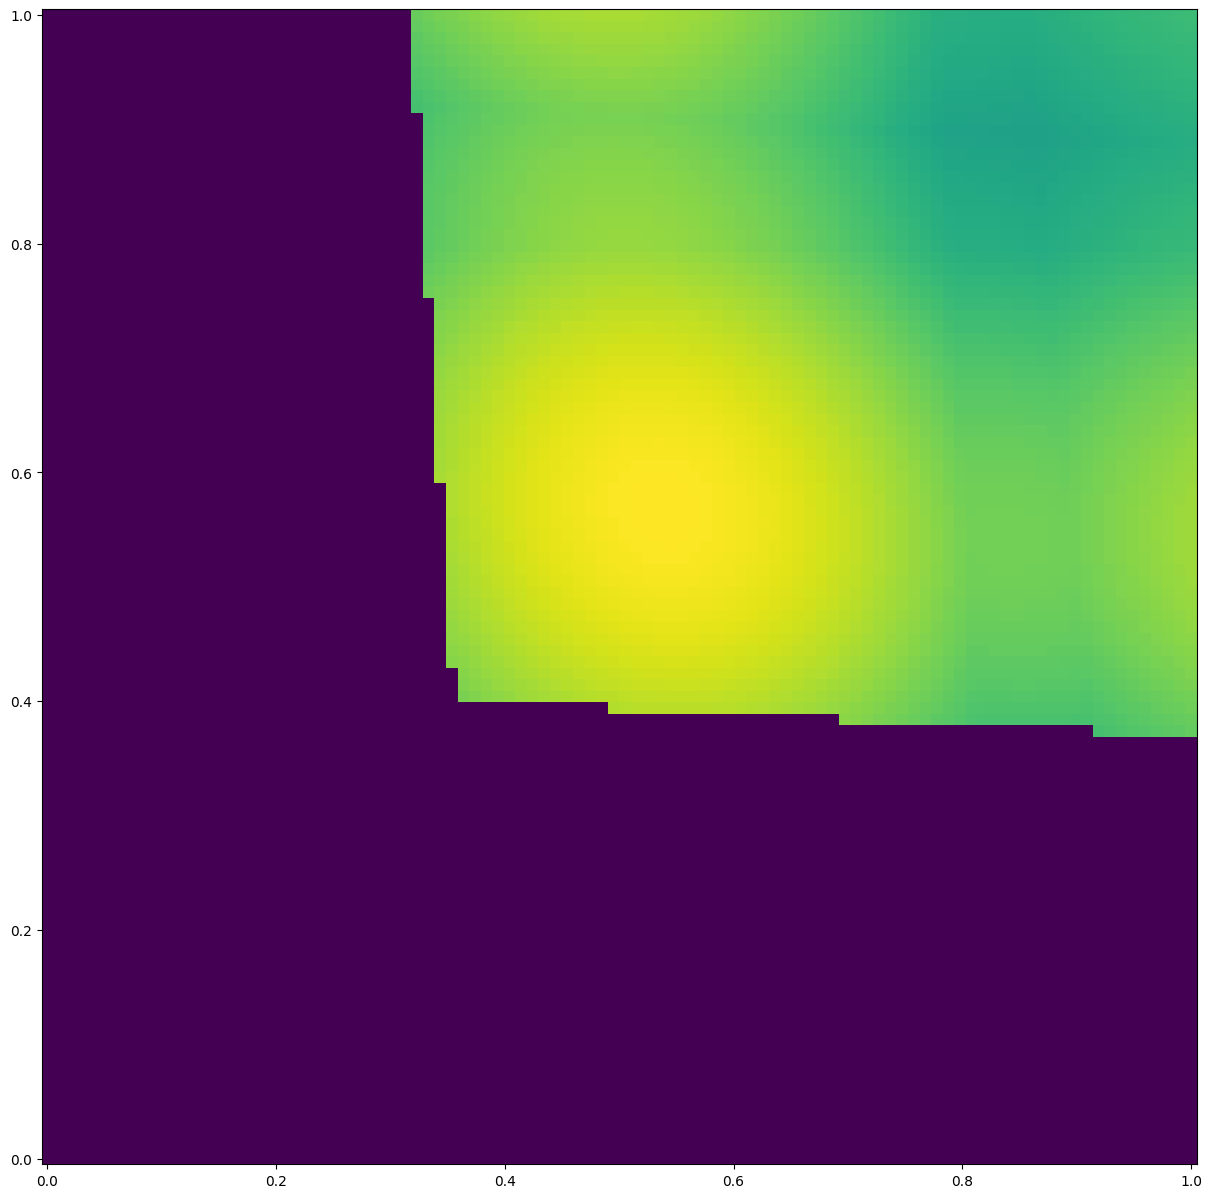

 16%|██████▍                                 | 319/2000 [02:26<11:19,  2.47it/s]

in-sample tci error 0.11588233642557966
loss tensor([8.3992e-07], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.797110666185363


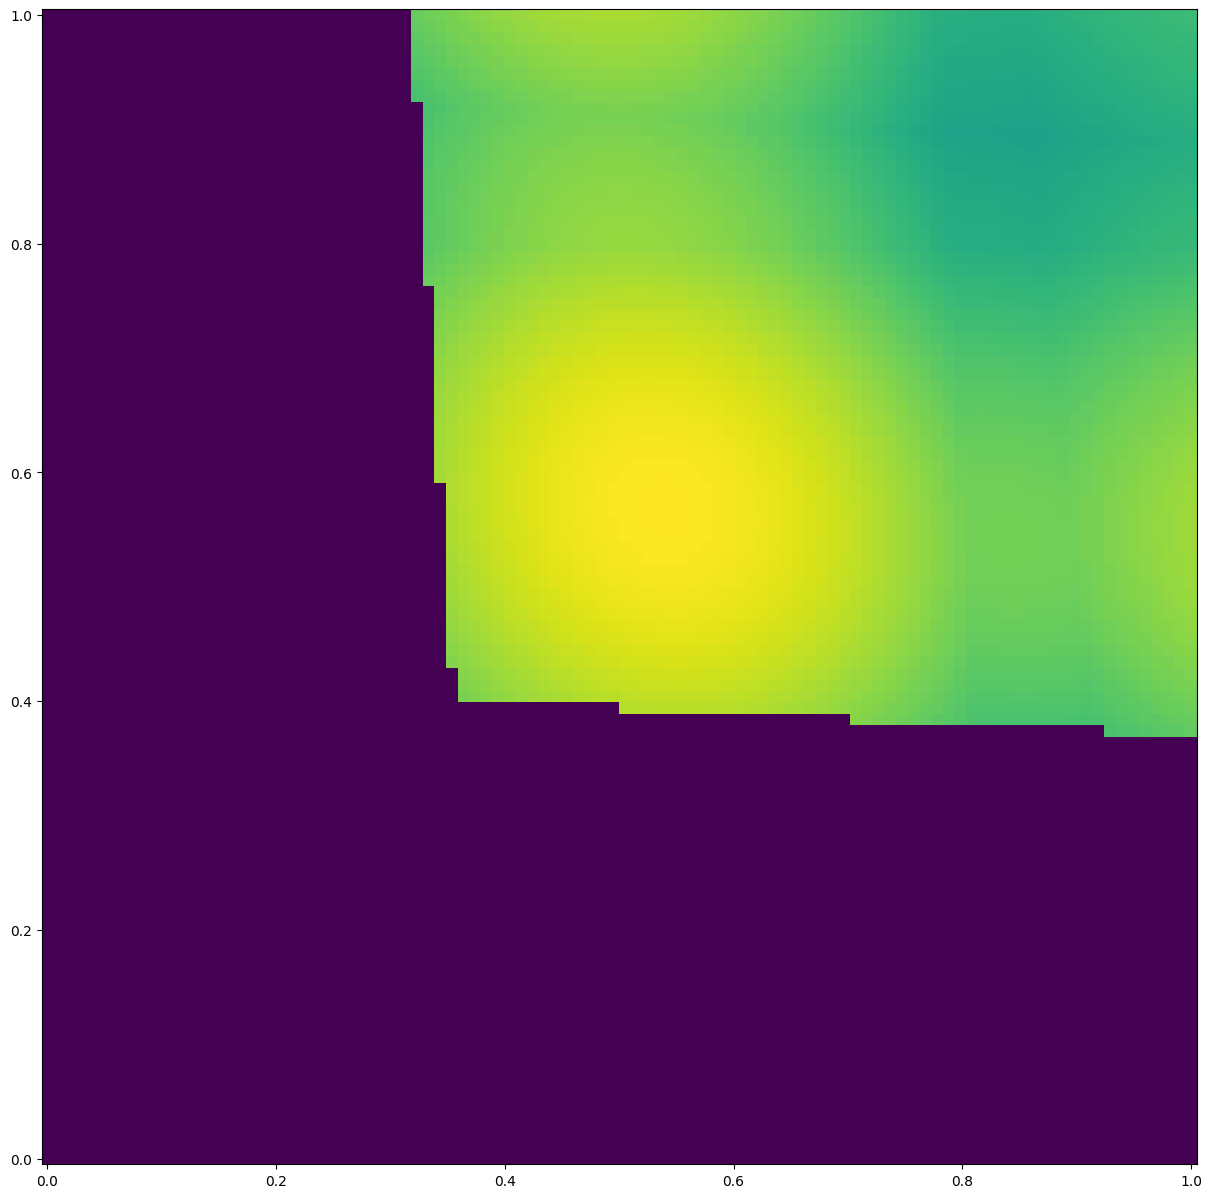

 17%|██████▊                                 | 339/2000 [02:35<11:22,  2.43it/s]

in-sample tci error 0.11510003599595953
loss tensor([8.2634e-07], grad_fn=<DivBackward0>)
MPS rank [(1, 10, 4), (4, 10, 1)]
integral error -3.7974871218982282


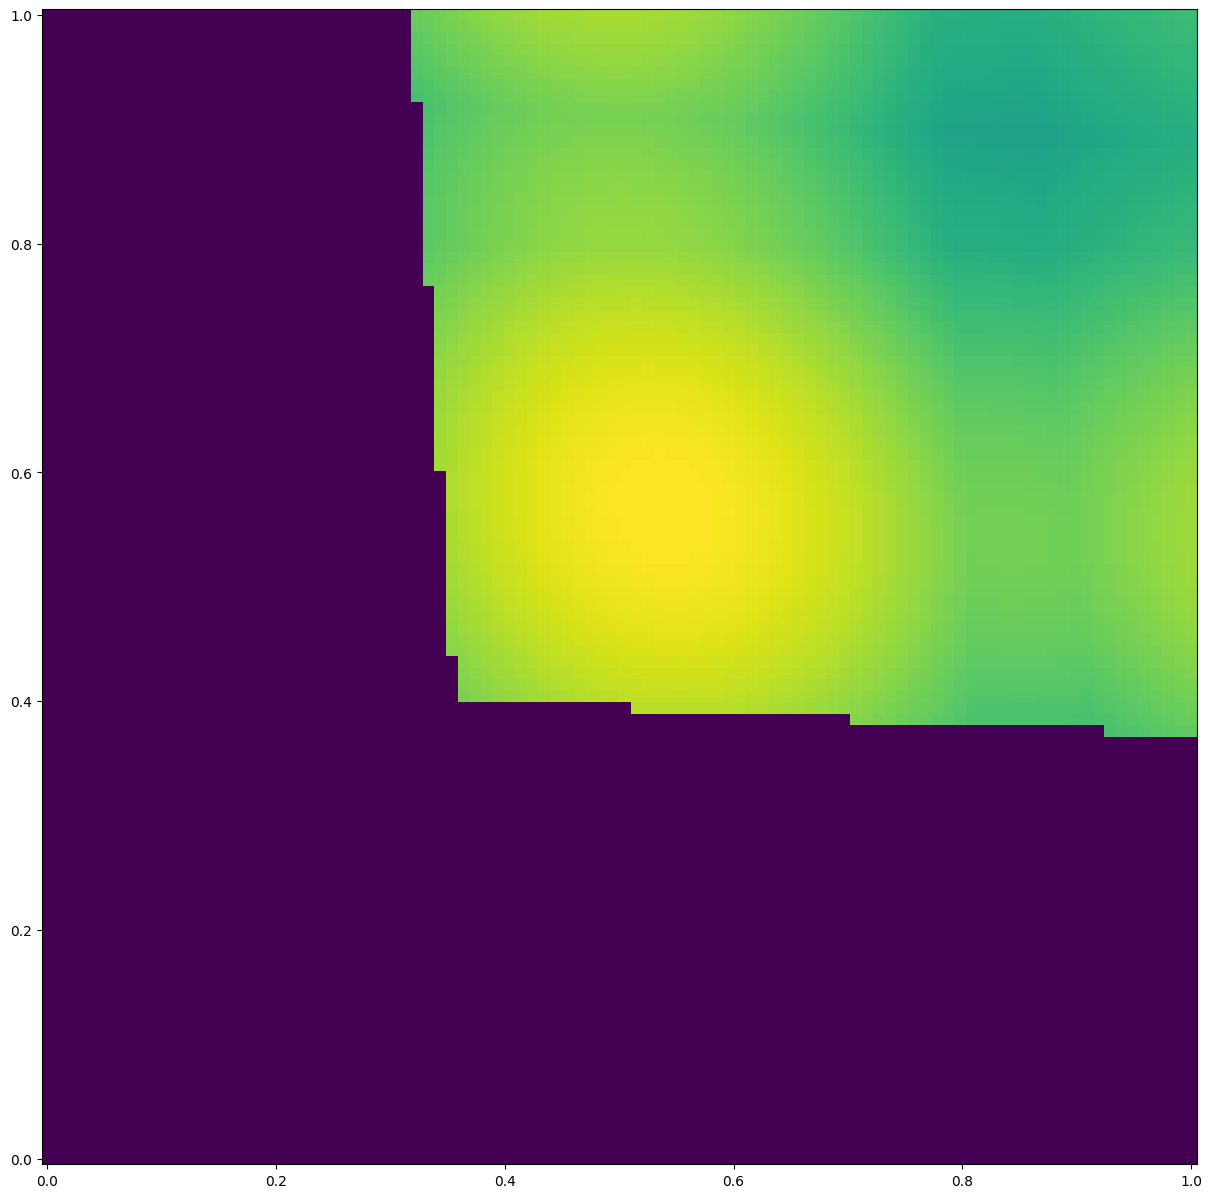

 17%|██████▉                                 | 348/2000 [02:40<12:40,  2.17it/s]


KeyboardInterrupt: 

In [10]:
#A wrapper 
def prob_model(z_list):
    z =torch.tensor(z_list)
    #print(xsize, x_input)
    z = torch.reshape(z, (1, len(z_list)))
    x, logJ = nfm.forward_and_log_det(z)
    return torch.exp(nfm.p.log_prob(x) + logJ)

# Train model
max_iter = 2000
num_samples = 1000
show_iter = 20
clip = 10.0

loss_hist = np.array([])


optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3)#, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_iter)
xell = np.linspace(0.0, 1.0, 10)
well = xell*0.0 + (xell[1]-xell[0])
unity = [1]*len(xell)
# Add weight to parameter envokes environment error mode
par = xfacpy.TensorCI1Param()
par.weight = [well] * ndims

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    #loss = nfm.reverse_kld(num_samples)
   
    tci = xfacpy.CTensorCI1(prob_model, [xell] * ndims)        
    hsweeps = range(1, 5)
    for hsweep in hsweeps:
        tci.iterate()
     
    
    Iset = tci.getIset()
    Jset = tci.getJset()
    o = list(range(len(xell)))
    loss = torch.zeros(1)
    for l in range(len(Jset)-1):
        Pi = Pitensor(Iset[l], o, o, Jset[l+1], xell, ndims, nfm)
        T1 = Ttensor(Iset[l], o, Jset[l], xell, ndims, nfm)
        P = Ptensor(Iset[l+1], Jset[l],xell, ndims, nfm)
        T2 = Ttensor(Iset[l+1], o, Jset[l+1],xell, ndims, nfm)
        err = insample_error(T1, P, T2, Pi)
        loss += torch.mean(err**2)
    loss = loss/(len(Jset)-1)
   
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
#         if (it+1)%show_iter == 0:
#             #print(loss, loss2)
#             # make_dot(z, params=dict(nfm.named_parameters()))
#             for name, param in nfm.named_parameters():
#                 print(f"Gradient of {name} is \n{param.grad}")
        torch.nn.utils.clip_grad_value_(nfm.parameters(), clip)
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        print("in-sample tci error",tci.pivotError[-1])
        print("loss",loss)
        print("MPS rank", [M.shape for M in tci.get_TensorTrain().core])
        print("integral error", tci.get_TensorTrain().sum([well]*ndims) - 4.0 )
        nfm.eval()
        log_prob = nfm.log_prob(zz)
        nfm.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.gca().set_aspect('equal', 'box')
        plt.show()
    #scheduler.step()


# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [ ]:
# Plot target distribution
# x_np, _ = make_moons(2 ** 20, noise=0.1)
# plt.figure(figsize=(15, 15))
# plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200)
# plt.show()

# Plot initial flow distribution
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(0.0, 1.0, grid_size), torch.linspace(0.0, 1.0, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

nfm.eval()
#log_prob = nfm.p.log_prob(zz).to('cpu').view(*xx.shape)
#prob = nfm.p.prob(zz).to('cpu').view(*xx.shape)
#prob = nfm.p.prob(zz).to('cpu').view(*xx.shape)
#print(prob, log_prob)
log_prob = nfm.q0.log_prob(zz).to('cpu').view(*xx.shape)
#print(prob)
#log_prob = log_prob - log_q
print(log_prob,log_q)
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()